# This notebook is for finding latest active addresses (and their selected token pairs) in pancakeswap. 

In [3]:
import pandas as pd
import math
import requests
import json
import numpy as np
import webbrowser
import time

from web3 import Web3
from web3.middleware import geth_poa_middleware

from hexbytes import HexBytes as hb
pd.set_option('display.max_columns', 500)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2
from functions_main import * # most functions are kept there for convenience
bsc_scan_api_key = "ID63Y14WNZY1NTAP8DEHN28KTC4NZAVHM4"
#"7ID9DCEPSKZM4EHW8UZE8YC4SF6CFRPRC9"
binance_provider = 'https://bsc-dataseed.binance.org' 
w3 = Web3(Web3.HTTPProvider(binance_provider))



pair_address="0xb5d7cc509f9de98e35f054392666122fdd4def47" # token_names = {"token0":"DARK","token1":"BUSD"}
#  information about the pair
abi = get_bsc_contract_abi(bsc_scan_api_key, pair_address) # gets an abi for the pair contract - it is universal for pancakeswap at least
token_abi = get_bsc_contract_abi(bsc_scan_api_key, "0x55d398326f99059fF775485246999027B3197955") # get a generic token abi to be able to read token contract symbol
pair_info = get_pair_info(pair_address,abi,bsc_scan_api_key,w3,token_abi) # get pair info
# need this only to parse Swap data using abi event signatures 
signatures = get_signatures_from_abi(abi) # extracts signatures of events in abi - it is universal for pancakeswap at least

pair_info["signatures"] = signatures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get the latest transactions in pancake_swap from bsc_scan_api
##### (seems much faster than using web3)

In [8]:
# write hours that you want to scrape
scrape_last_hours = 6
# BSC blocks are once every 3 seconds
blocks_every_n_seconds = 3

blocks_ago = scrape_last_hours*60*60//3
results=get_bsc_historical_pancake_swaps(fromBlock=w3.eth.blockNumber-blocks_ago, toBlock=w3.eth.blockNumber, bsc_scan_api_key=bsc_scan_api_key)

getting BSC Historical Logs from block 23935863 to block 23943063...
Found 1000 txs from 23935863 block to 23935933 block.
Found 1000 txs from 23935933 block to 23936008 block.
Found 1000 txs from 23936008 block to 23936084 block.
Found 1000 txs from 23936084 block to 23936166 block.
Found 1000 txs from 23936166 block to 23936237 block.
Found 1000 txs from 23936237 block to 23936307 block.
Found 1000 txs from 23936307 block to 23936368 block.
Found 1000 txs from 23936368 block to 23936441 block.
Found 1000 txs from 23936441 block to 23936516 block.
Found 1000 txs from 23936516 block to 23936592 block.
Found 1000 txs from 23936592 block to 23936664 block.
Found 1000 txs from 23936664 block to 23936733 block.
Found 1000 txs from 23936733 block to 23936807 block.
Found 1000 txs from 23936807 block to 23936871 block.
Found 1000 txs from 23936871 block to 23936923 block.
Found 1000 txs from 23936923 block to 23936972 block.
Found 1000 txs from 23936972 block to 23937030 block.
Found 1000 tx

## Crude analysis and filtering of addresses 

In [14]:
# FILTER OUT AND ANALYSE ACTIVE ADDRESSES

df = pd.DataFrame(results) # turn the list of dictionary to pandas dataframe
df = parse_results_dataframe(df,pair_info) # parse the tx info 

# drop Swap receivers that are known token addresses or token pairs. 

# swapping_contracts=[
#     "0x10ed43c718714eb63d5aa57b78b54704e256024e", # PancakeSwap: Router v2 contract address 
#     "0x7efaef62fddcca950418312c6c91aef321375a00", # Pancake LPs (Cake-LP)
#     "0x16b9a82891338f9ba80e2d6970fdda79d1eb0dae", # USDT/WBNB
#     "0x58f876857a02d6762e0101bb5c46a8c1ed44dc16", # WBNB/USDT
#     "0x804678fa97d91b974ec2af3c843270886528a9e6", # Cake/BUSD
#     "0x0ed7e52944161450477ee417de9cd3a859b14fd0", # Cake/WBNB
#     "0x90c7c04457f3649a50bcbfa5a6b0711dd093b5ce", # WBNB/DW2
#     "0xbb6e2f4f94c2f5907379f0675a92a0c20c1bed31", # WBNB/ToolDOGE
#     "0x804678fa97d91b974ec2af3c843270886528a9e6", # Cake/BUSD
# ] # it is endless
swapping_contracts = list(set(df.contract_address)) + [
    "0x10ed43c718714eb63d5aa57b78b54704e256024e",# PancakeSwap: Router v2 contract address 
    "0x000000000000000000000000000000000000dead",# null address for token burning
] 
df = df[~df['To'].isin(swapping_contracts)] # drop swaps that contain these addresses as to. Only can contain (and will contain) as From for simple swaps

hour_window = (df.timeStamp.max() - df.timeStamp.min()) / (60*60)
print(f"Table contains {len(df)} txs from {df.DateTime.min()} to {df.DateTime.max()}, which is {round(hour_window,2)} hour window")


# Crude analysis of every address: txs_from_address, percent_txs_from_address
all_swaps=df[df.event == "Swap"]
total_token1_volume_by_all_addresses = (all_swaps["amount1In"].sum() + all_swaps["amount1Out"].sum())
total_token0_volume_by_all_addresses = (all_swaps["amount0In"].sum() + all_swaps["amount0Out"].sum())
# Select a treshold of swaps that need to be made by any single address to stay in dataframe
all_swaps = keep_active_adresses(all_swaps = all_swaps, at_least_swaps = 5) # rapidly filters out the majority of adresses that had very few swaps

# get percent fraction of txs made by this address compared to all txs
all_swappers = set(all_swaps.dropna(subset=["To"]).To.to_list())
all_swappers.discard(pair_address)
all_swappers.discard("0x0000000000000000000000000000000000000000")
iteration=0
# total_token1_volume_by_all_addresses = (all_swaps["amount1In"].sum() + all_swaps["amount1Out"].sum())
# total_token0_volume_by_all_addresses = (all_swaps["amount0In"].sum() + all_swaps["amount0Out"].sum())
analyzed_swaps = pd.DataFrame()
for address in list(all_swappers):
    # print(address)
    address_swaps= all_swaps[(all_swaps.To == address)].copy()
    if len(address_swaps)<4:
        # print("skipping")
        continue
    iteration+=1
    print(f"Analysing address {iteration} out of {len(list(all_swappers))}", end = "\r")
    address_swaps["txs_from_address"] = len(address_swaps)
    address_swaps["percent_txs_from_address"] = round((len(address_swaps)/len(all_swaps)*100), 4)  # len(txs) / len(swaps) * 100%

    # find sandwitch bots: quick way: check how many txs were in the same block
    # address_swaps["txs_in_same_block"] = len(set(address_swaps.transactionHash)) - len(set(address_swaps.drop_duplicates("transactionHash").blockNumber))
    most_common_pair_address = max(set(address_swaps.contract_address.to_list()), key = address_swaps.contract_address.to_list().count) 
    address_swaps["most_common_pair_address"] = most_common_pair_address
    address_swaps["focused_on_single_pair"] = (len(set(address_swaps.contract_address.to_list())) == 1)

    # measure volume
    total_amount1Out_by_address = sum(address_swaps["amount1Out"])
    total_amount1In_by_address = sum(address_swaps["amount1In"])
    address_swaps["total_amount1Out_by_address"]= total_amount1Out_by_address # selects where to is the address and prescribes a value which is sum of this same table 
    address_swaps["total_amount1In_by_address"]= total_amount1In_by_address
    address_swaps["total_token1_volume_by_address"]= total_amount1Out_by_address + total_amount1In_by_address

    total_amount0Out_by_address = sum(address_swaps["amount0Out"])
    total_amount0In_by_address = sum(address_swaps["amount0In"])
    address_swaps["total_amount0Out_by_address"]= total_amount0Out_by_address # selects where to is the address and prescribes a value which is sum of this same table 
    address_swaps["total_amount0In_by_address"]= total_amount0In_by_address
    address_swaps["total_token0_volume_by_address"]= total_amount0Out_by_address + total_amount0In_by_address

    # measure percent fraction of volume: (total address volume) / (total volume by all addresses) * 10
    address_swaps["percent_token1_volume_by_address"] = (total_amount1Out_by_address + total_amount1In_by_address) / total_token1_volume_by_all_addresses * 100
    address_swaps["percent_token0_volume_by_address"] = (total_amount0Out_by_address + total_amount0In_by_address) / total_token0_volume_by_all_addresses * 100
    
    # HERE FILTER OUT THE MOST COMON PAIR ADDRESS AND CONTINUE ANALYSIS
    address_swaps = address_swaps[address_swaps.contract_address == most_common_pair_address] 

    # count how many txs appear in same block
    address_swaps["txs_in_same_block"] = address_swaps.drop_duplicates("transactionHash").duplicated(subset=["contract_address", "blockNumber"]).sum()

    # Quantify if address is mostly buying, selling or both. Quantify the position in terms of buy/sell ratio 
    position_ratio = (address_swaps.amount0In.sum() + address_swaps.amount1Out.sum() + 1) / (address_swaps.amount1In.sum() + address_swaps.amount0Out.sum() + 1)
    if position_ratio < 1:
        position_ratio = 1/position_ratio
    address_swaps["position_ratio"] = position_ratio

    # Many bad market makers use same amounts of tokens for trades - quantify the similarity of these amounts to indicate crappy bot - 0 if no simmilarity, 1 if maximum similarity
    token0_ammount_similarity = 1 - (len(set(address_swaps.amount0Out + address_swaps.amount0In)) / len(address_swaps)) # 1 / (fraction unique)
    token1_ammount_similarity = 1 - (len(set(address_swaps.amount1Out + address_swaps.amount1In)) / len(address_swaps)) # 1 / (fraction unique)
    tx_size_similarity = max(token0_ammount_similarity, token1_ammount_similarity) # chose the larger one
    address_swaps["tx_size_similarity"] = tx_size_similarity

    # Calculation of profits - DOES NOT ACCOUNT FOR DECIMALS AS IT TAKES TOO LONG TO GET PAIR CONTRACT INFO. NEED TO STORE DECIMAL DATA LOCALLY
    # Get token price, which is simply a ratio of the Swap
    token0_price_in_token1 = pd.to_numeric((address_swaps.amount1In + address_swaps.amount1Out) / (address_swaps.amount0In + address_swaps.amount0Out)) #* (10**(pair_info["token0_decimals"]-pair_info["token1_decimals"])) # accounting for token decimals shown in contract
    token1_price_in_token0 = 1 / token0_price_in_token1
    # Get current accumulated position
    position_token0 = (address_swaps.amount0Out.sum() - address_swaps.amount0In.sum()) #* 10**-pair_info["token0_decimals"]
    position_token1 = (address_swaps.amount1Out.sum()  - address_swaps.amount1In.sum()) #* 10**-pair_info["token1_decimals"]
    # Get profits in terms of token0 and token1 
    address_position_token0 = position_token0 + (position_token1 * token1_price_in_token0.iloc[-1]) # token1_price_in_token0 is series - take only last item!
    address_position_token1 = position_token1 + (position_token0 * token0_price_in_token1.iloc[-1])
    address_swaps['profit_in_token0'] = address_position_token0
    address_swaps['profit_in_token1'] = address_position_token1

    # put to dataframe
    analyzed_swaps = pd.concat([analyzed_swaps, address_swaps[["percent_txs_from_address", "txs_from_address", "txs_in_same_block", "position_ratio", "tx_size_similarity", "focused_on_single_pair", "most_common_pair_address", "profit_in_token0", "profit_in_token1"
    # "total_amount1Out_by_address","total_amount1In_by_address","total_token1_volume_by_address","total_amount0Out_by_address","total_amount0In_by_address","total_token0_volume_by_address","percent_token1_volume_by_address","percent_token0_volume_by_address"
    ]]])

df = all_swaps

display(df.head())
# 17.3 s for 3833 adresses

Throwing out 0 txs
Table contains 73067 txs from 2022-12-15 21:20:47 to 2022-12-16 03:26:58, which is 6.1 hour window


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out
17677,0x51d6e1dbe1bd149259a17594e1394de7634241ce,0x00000000000000000000000000000000000000000000...,23937074,0xd7b517a40fd7c0b2323eb963f9435fc15950d0479c56...,1671142927,6728049335,149073,13,0x00fac94ec3f1d7f9aa878ffcdf9bc2f1be18780a405f...,8,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x000000006ca46f7741fe1b38ea3c3d3d39d6265f,2022-12-15 22:22:07,0,2304324001717174016,568620230967898952912433704661,0
83629,0x6657f5cec7404c96dbc204c8bdf5452c5a779c5c,0x00000000000000000000000000000000000000000000...,23941413,0x51388fc96409c9c9c7c6317a53710294d2f1da020a52...,1671156178,5179647692,152573,86,0x30fcd50905358d8a82742164a149e64469880e231392...,14,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x000000006ca46f7741fe1b38ea3c3d3d39d6265f,2022-12-16 02:02:58,3152404668846687231110,0,0,1670008348329971715
42590,0xce7205b0f1b37b9d4339a817d8337fd60be853d1,0x00000000000000000000000000000000000000000000...,23938831,0x34fabd796238c7ff3bd1f4276ae13c8ffcaa40e32053...,1671148214,5286764447,187388,61,0x2c41f4eebf380527b2a14e6daec47b313c12448053e4...,7,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x000000006ca46f7741fe1b38ea3c3d3d39d6265f,2022-12-15 23:50:14,8575318620705315932960,0,0,259007633685407417
44188,0xe0f79889dc52625e601a97f6a5fa9f0284992053,0x00000000000000000000000000000000000000000000...,23938957,0x759370f561cf8f92e876ee59ee5bc87a6da7ac05a732...,1671148592,5514405426,161521,62,0xadd761868bf96a4832468b10c11f63a17d5bc71766df...,29,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x000000006ca46f7741fe1b38ea3c3d3d39d6265f,2022-12-15 23:56:32,0,121879335057816216,1350781785651,0
77844,0x51d6e1dbe1bd149259a17594e1394de7634241ce,0x000000000000000000000000000000000000000ab75a...,23941031,0x3214bfe8ec4a023c3e2a6881dd283890037bb44a5a40...,1671155032,5297240612,128725,75,0x7fc8d495b4933a4aec8e95e5265bb090a39022b6d7e7...,22,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x000000006ca46f7741fe1b38ea3c3d3d39d6265f,2022-12-16 01:43:52,849026692706386690772333232146,0,0,3380784612139528368


953


/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(24, 22)
(53, 22)
9.974088304302794e-32
(128, 22)
(0, 22)
0.00029829066125540573
(180, 22)
(13, 22)
0.029419859057160443
(1233, 22)
(177, 22)
3.034448720548395
(12, 22)
(1, 22)
1.0297223403290088


/Users/hkrukauskas/Data Science Capstone/functions_main.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["swap_size"] = np.log2(
/Users/hkrukauskas/Data Science Capstone/functions_main.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["is_buying"] = pd.to_numeric(


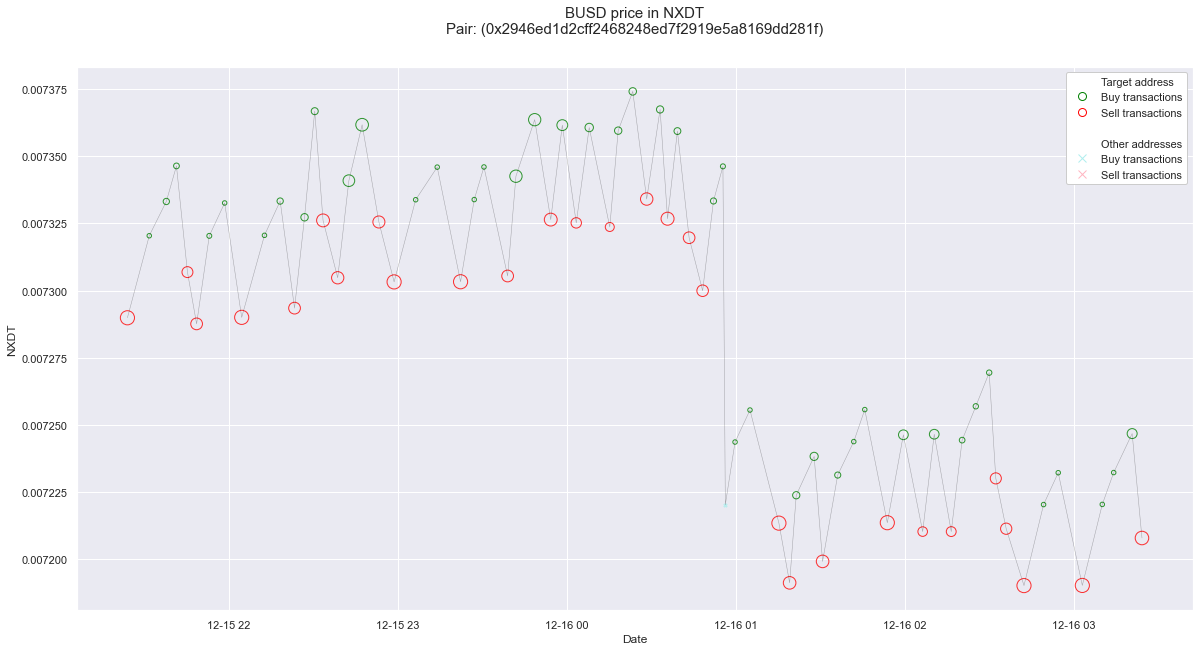

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(21, 22)
(3, 22)
1.0051810739697482


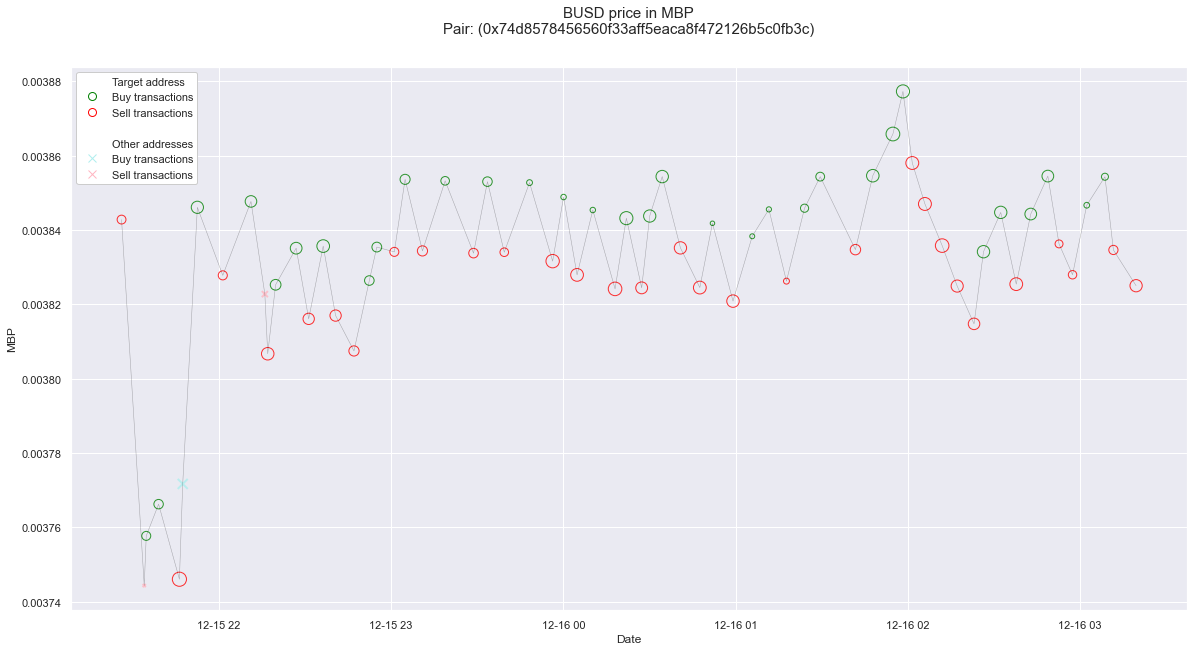

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(681, 22)
(5, 22)
0.8429926509310073


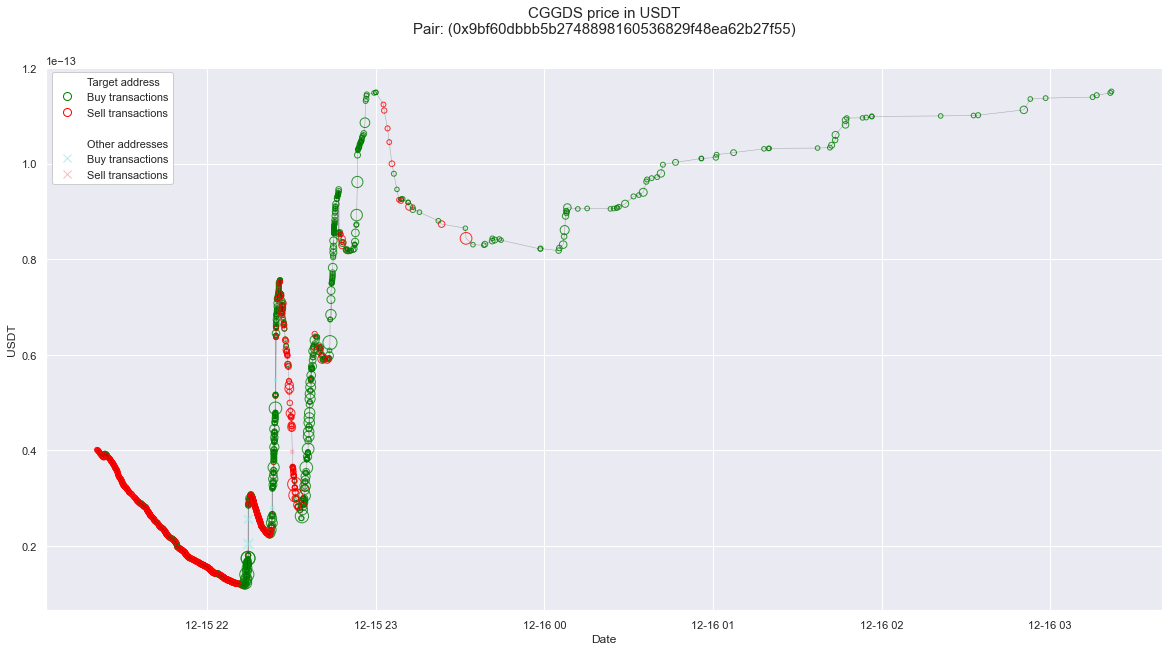

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(140, 22)
(3, 22)
1.5943511170904494
(185, 22)
(104, 22)
4.573705345743529
(8, 22)
(18, 22)
2.9287879830584655
(44, 22)
(15, 22)
0.006943700494082263
(35, 22)
(272, 22)
19.431119980658533
(22, 22)
(15, 22)
0.03472170354668492
(22, 22)
(1, 22)
1.2560235152774915
(50, 22)
(139, 22)
0.6447774390544405
(14, 22)
(0, 22)
0.6490007272161095
(18, 22)
(11, 22)
7.814608954690904e+22
(17, 22)
(0, 22)
0.005386415072769951
(25, 22)
(0, 22)
551.526673459362
(13, 22)
(0, 22)
1.0328927562223047


/Users/hkrukauskas/Data Science Capstone/functions_main.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["swap_size"] = np.log2(
/Users/hkrukauskas/Data Science Capstone/functions_main.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["is_buying"] = pd.to_numeric(


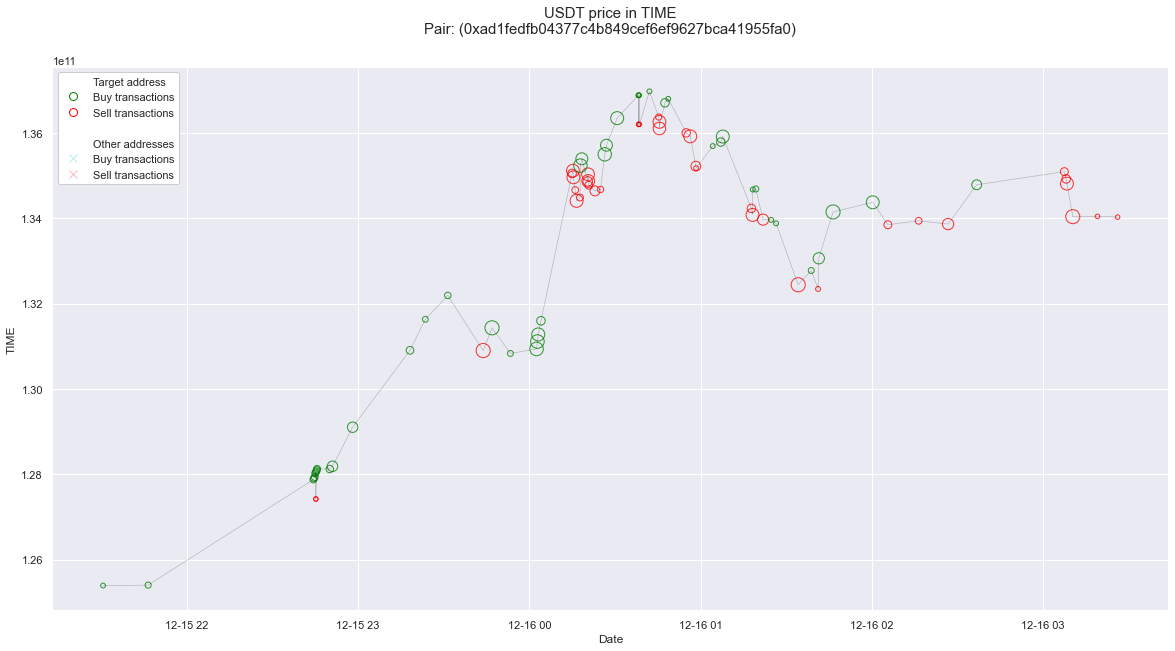

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(17, 22)
(0, 22)
1.0742590929656133


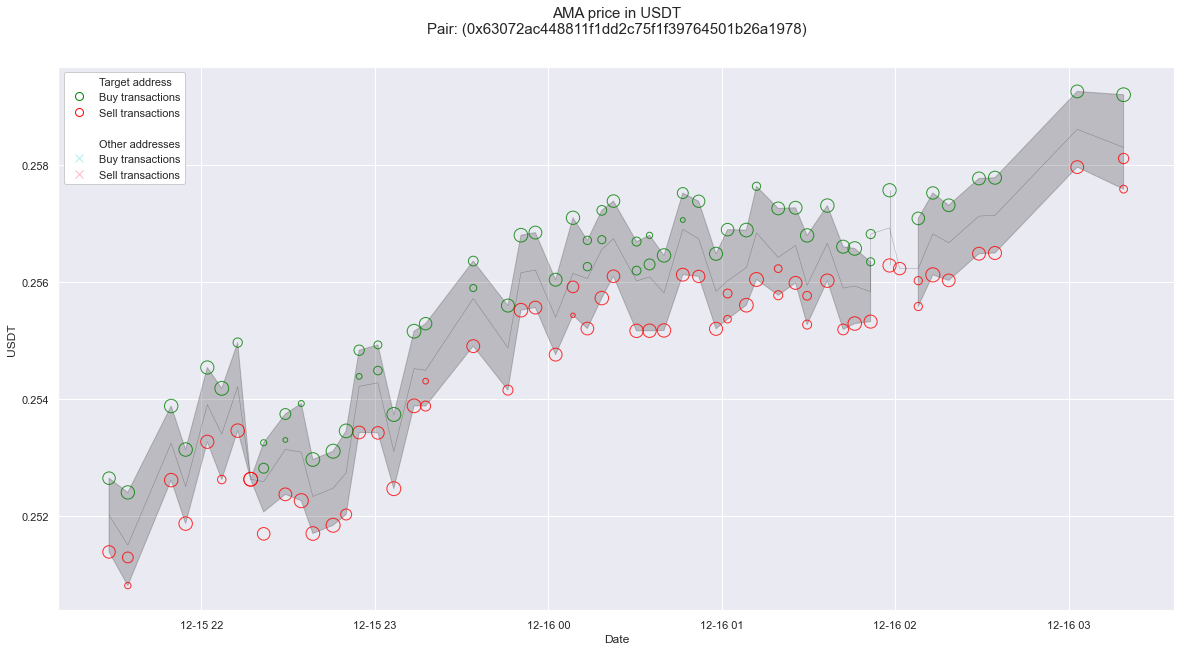

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(11, 22)
(0, 22)
1.2444058667850375
(59, 22)
(3, 22)
2.924653437917931
(62, 22)
(19, 22)
0.10055843205384235
(62, 22)
(195, 22)
0.6521570999807187
(78, 22)
(1, 22)
4.382617784737061e+22
(13, 22)
(0, 22)
0.9845809275151951


/Users/hkrukauskas/Data Science Capstone/functions_main.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["swap_size"] = np.log2(
/Users/hkrukauskas/Data Science Capstone/functions_main.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["is_buying"] = pd.to_numeric(


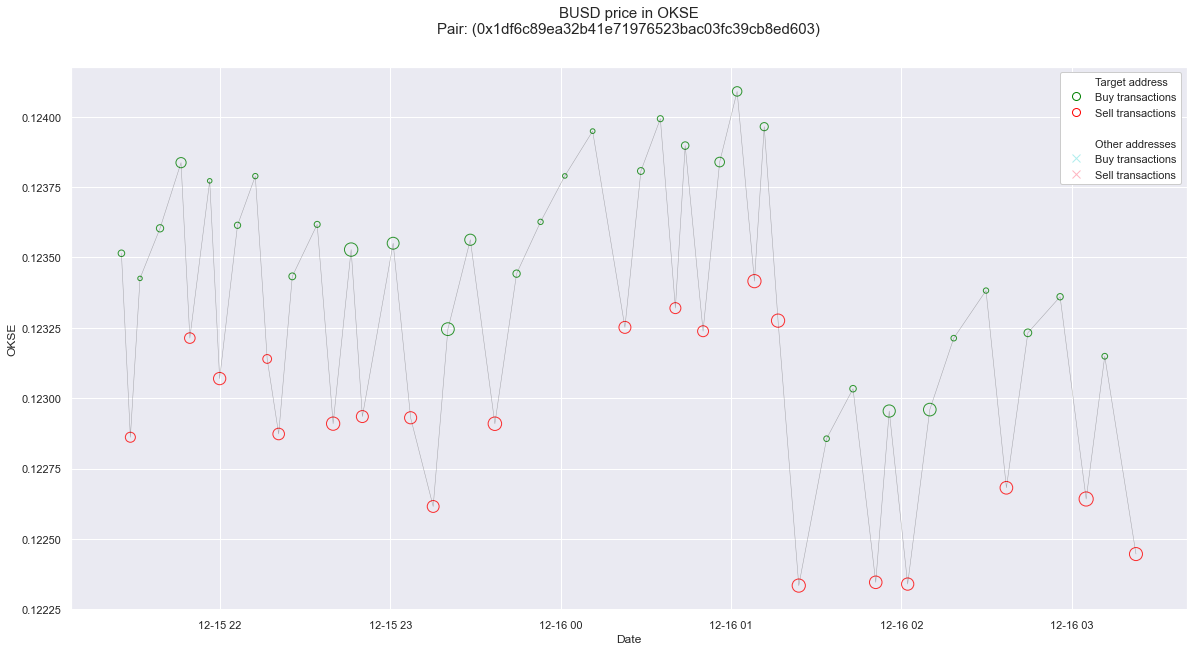

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(216, 22)
(10, 22)
4.198074251719502e+30
(19, 22)
(2, 22)
27.71744745761777
(73, 22)
(3, 22)
0.18411612446717726
(7, 22)
(19, 22)
30.50018615688999
(8, 22)
(0, 22)
0.8561459371194243


/Users/hkrukauskas/Data Science Capstone/functions_main.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["swap_size"] = np.log2(
/Users/hkrukauskas/Data Science Capstone/functions_main.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["is_buying"] = pd.to_numeric(


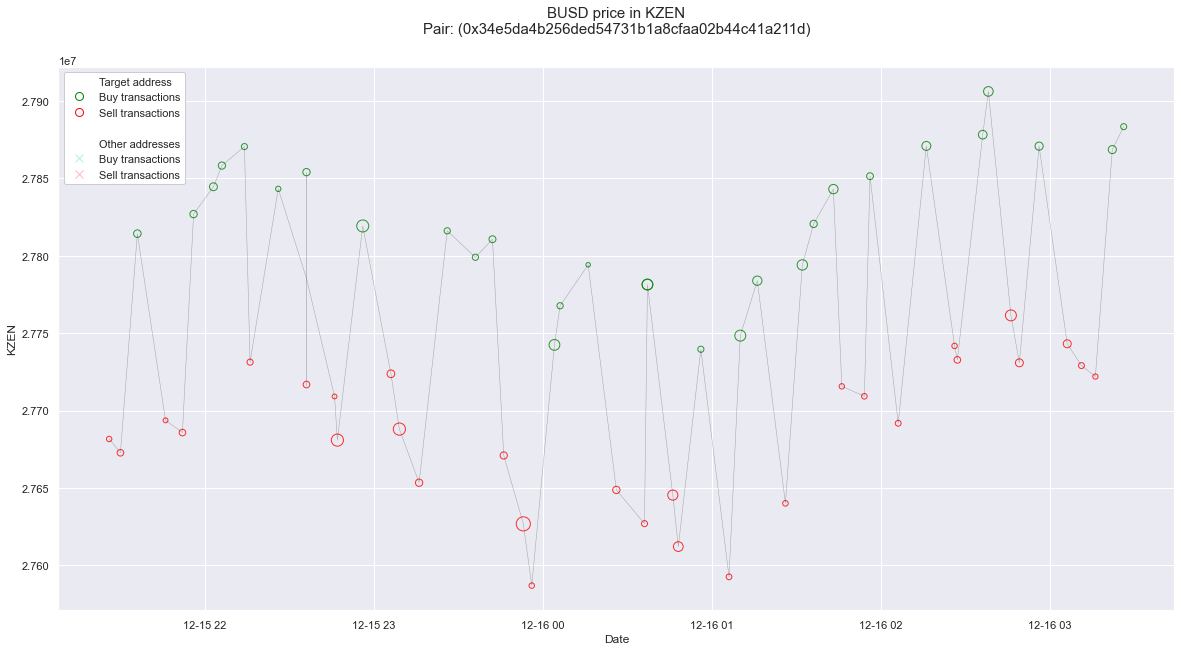

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(89, 22)
(109, 22)
1.2348086674078105
(15, 22)
(1, 22)
2.2678822386784117e-24
(223, 22)
(0, 22)
1.0508938037013795


/Users/hkrukauskas/Data Science Capstone/functions_main.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["swap_size"] = np.log2(
/Users/hkrukauskas/Data Science Capstone/functions_main.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["is_buying"] = pd.to_numeric(


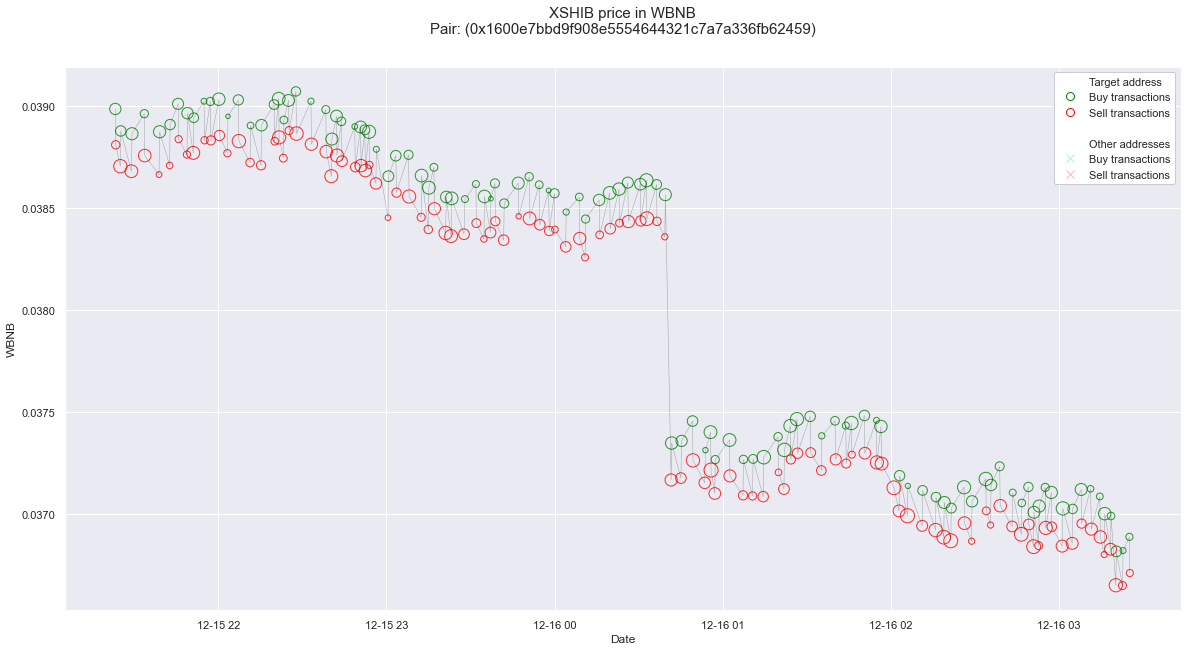

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(66, 22)
(7, 22)
0.9188739362143372


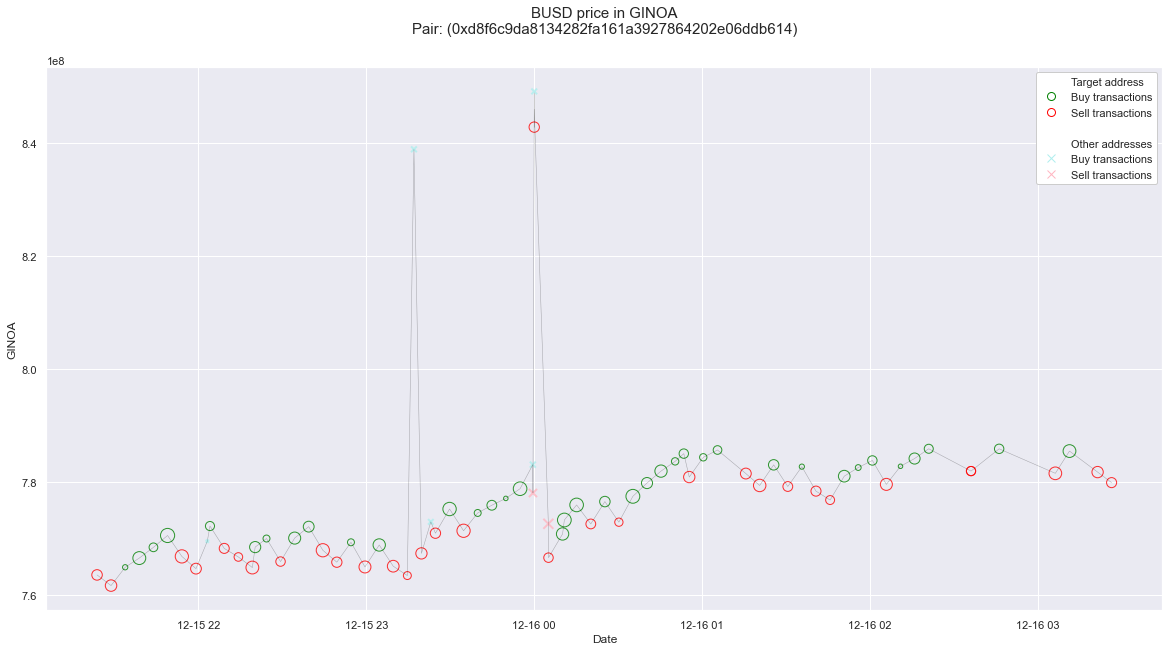

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(12, 22)
(11, 22)
5.980409673768066e-24
(55, 22)
(18, 22)
7.399546193544844e-21
(26, 22)
(0, 22)
1.135532829072304


/Users/hkrukauskas/Data Science Capstone/functions_main.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["swap_size"] = np.log2(
/Users/hkrukauskas/Data Science Capstone/functions_main.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["is_buying"] = pd.to_numeric(


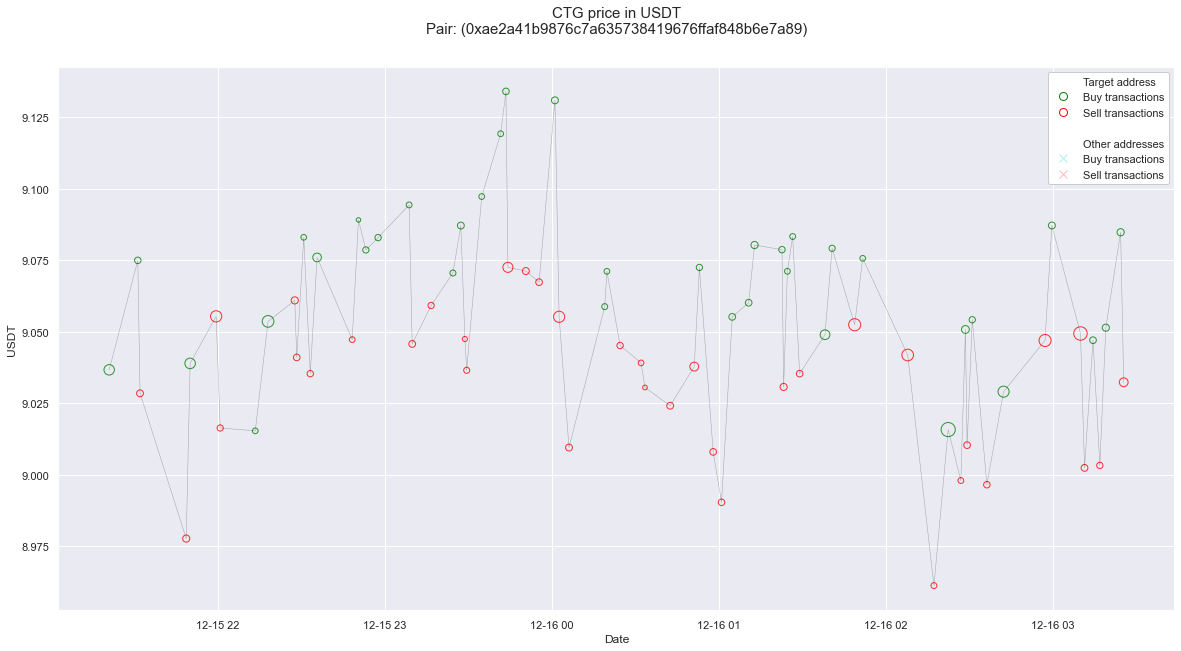

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(172, 22)
(4, 22)
7.411434320441273
(25, 22)
(3, 22)
1.4475616625929802e-25
(18, 22)
(0, 22)
0.9615752376503036


/Users/hkrukauskas/Data Science Capstone/functions_main.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["swap_size"] = np.log2(
/Users/hkrukauskas/Data Science Capstone/functions_main.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["is_buying"] = pd.to_numeric(


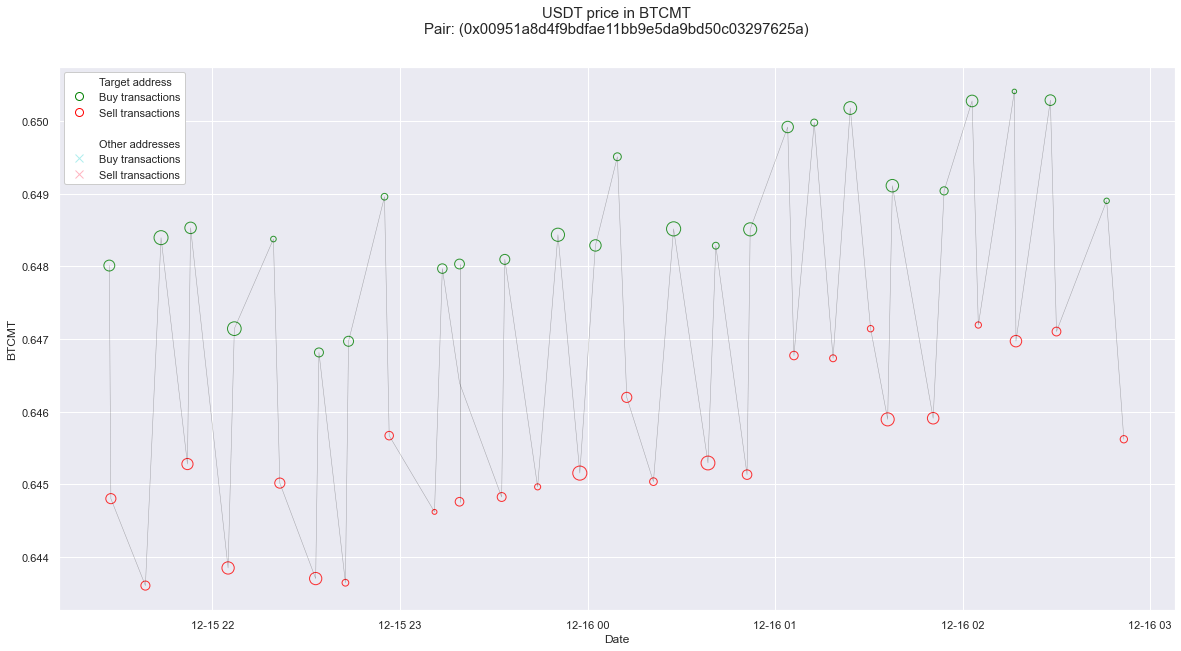

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(10, 22)
(2, 22)
0.8801352991671205


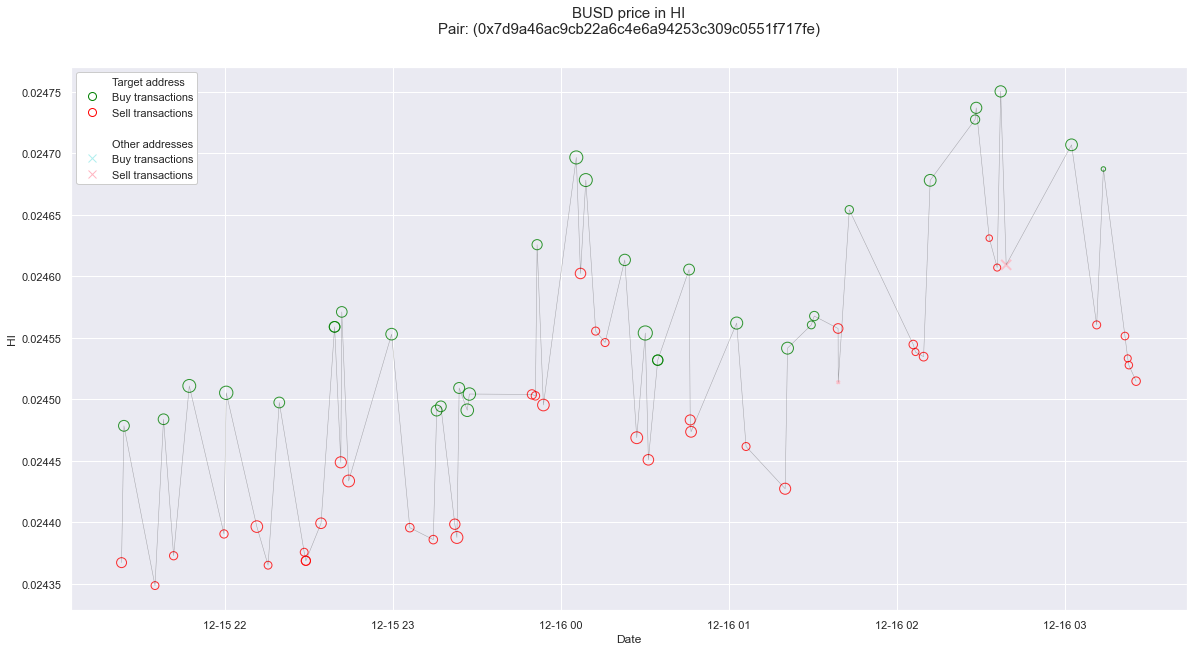

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(303, 22)
(0, 22)
6.591537141911684e-24
(812, 22)
(18, 22)
10657.621578586975
(46, 22)
(16, 22)
8.613555758303799e-19
(121, 22)
(4, 22)
55.91949450508418
(55, 22)
(1, 22)
1.7674538415688217e-18
(60, 22)
(2, 22)
5.946156549817027
(173, 22)
(36, 22)
5.813069575570578e-19
(64, 22)
(0, 22)
1.0014751917517555


/Users/hkrukauskas/Data Science Capstone/functions_main.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["swap_size"] = np.log2(
/Users/hkrukauskas/Data Science Capstone/functions_main.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["is_buying"] = pd.to_numeric(


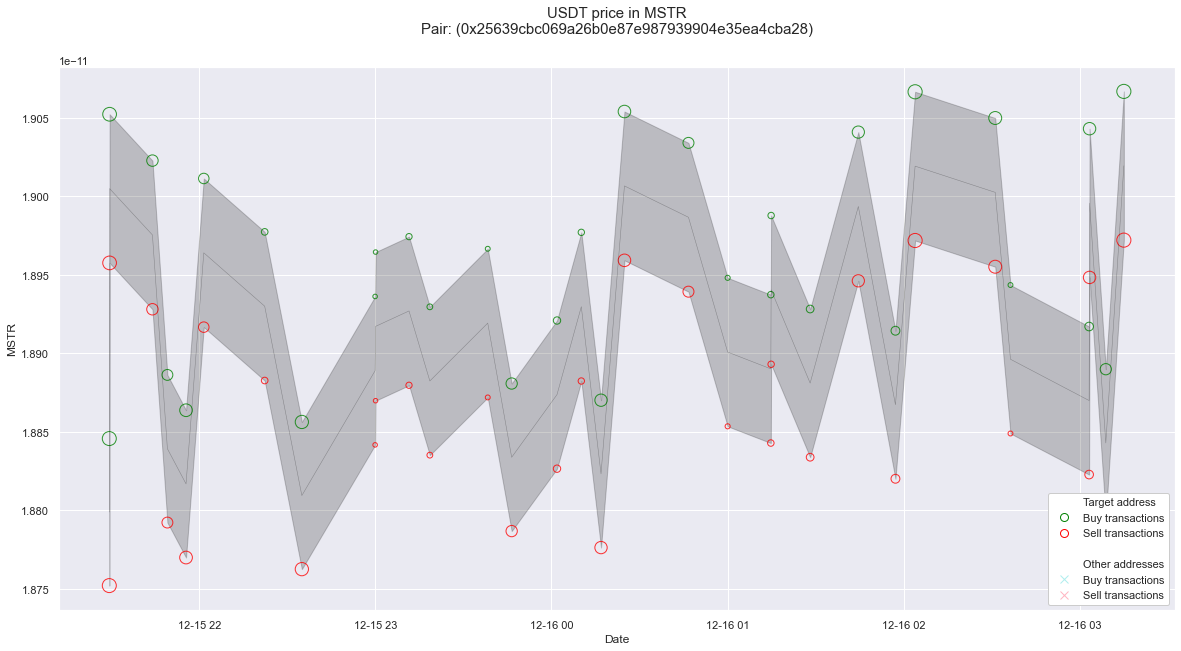

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(86, 22)
(22, 22)
0.04954416049379922
(20, 22)
(0, 22)
1.3643393282509675
(154, 22)
(14, 22)
0.07383033017524031
(100, 22)
(1, 22)
1.8904372351992647
(31, 22)
(0, 22)
4.484557183817519e-27
(13, 22)
(0, 22)
0.9641304141352127


/Users/hkrukauskas/Data Science Capstone/functions_main.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["swap_size"] = np.log2(
/Users/hkrukauskas/Data Science Capstone/functions_main.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["is_buying"] = pd.to_numeric(


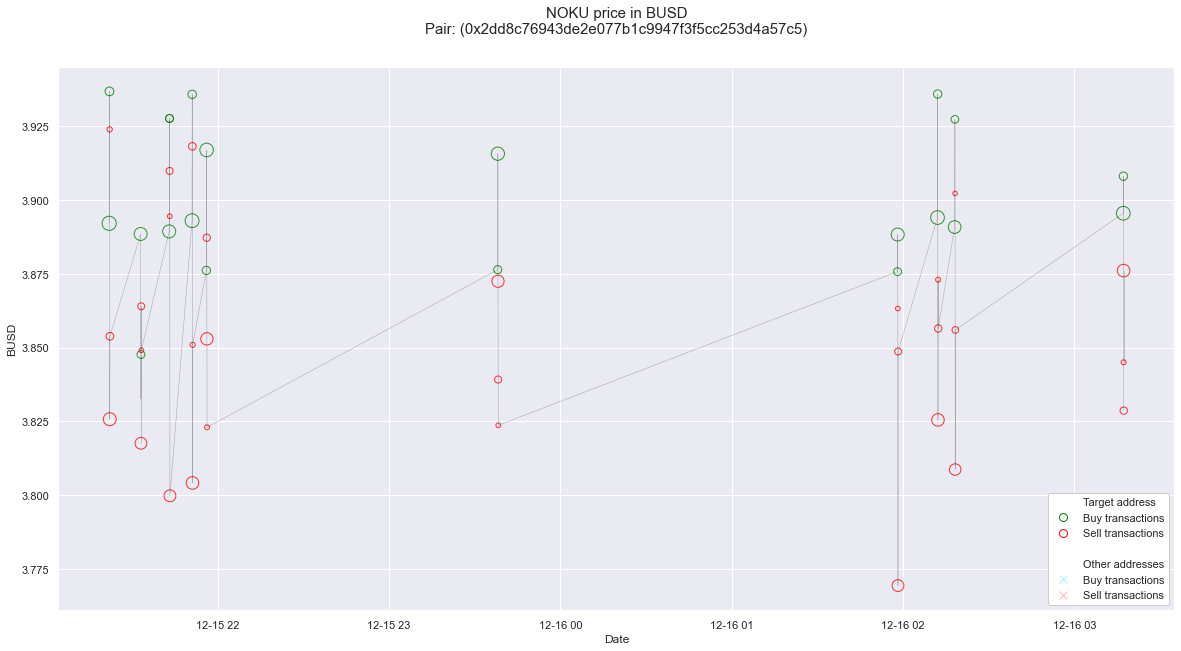

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(46, 22)
(1, 22)
1.2132939966941213e-23
(73, 22)
(0, 22)
1.369863013506766e-22
(51, 22)
(0, 22)
7.997744286874853e-26
(56, 22)
(0, 22)
1.1300654308325873


/Users/hkrukauskas/Data Science Capstone/functions_main.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["swap_size"] = np.log2(
/Users/hkrukauskas/Data Science Capstone/functions_main.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["is_buying"] = pd.to_numeric(


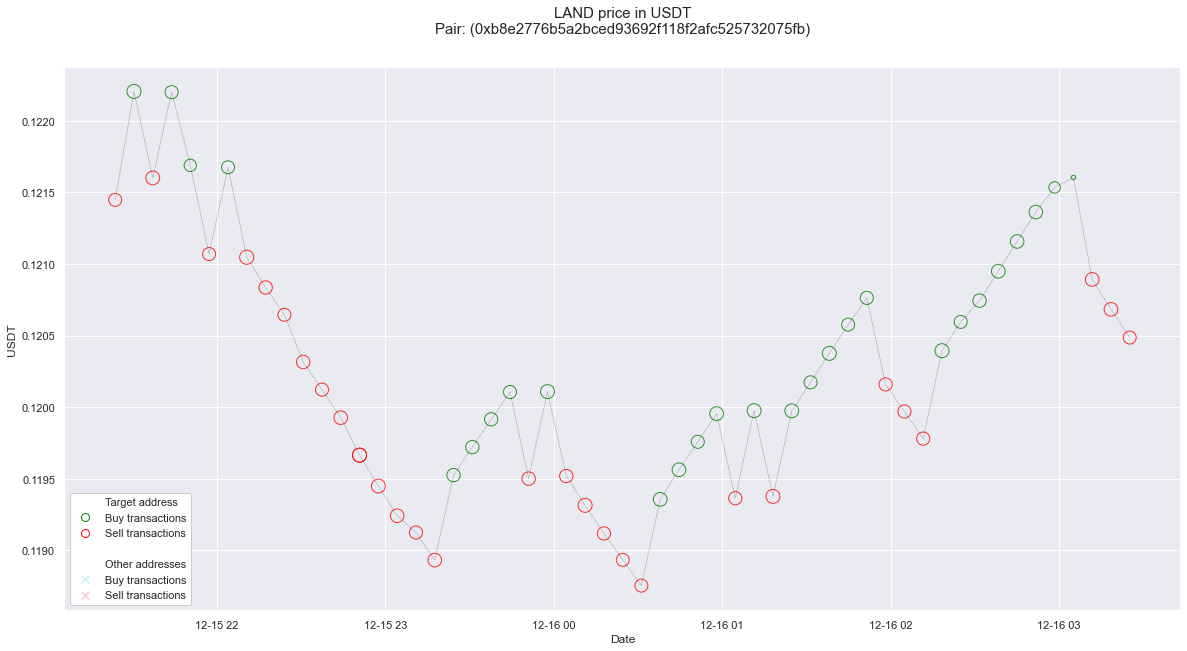

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a cop

(154, 22)
(6, 22)
2.2191082917226437e-22
(104, 22)
(1, 22)
0.7624940947511458
(75, 22)
(1, 22)
2.868497273874223e+19
(65, 22)
(3, 22)
2.2058718511459614e+22
(338, 22)
(8, 22)
3.556210257178986
(119, 22)
(0, 22)
1.8859723572914752e-20
(150, 22)
(1, 22)
0.9906358876613779


/Users/hkrukauskas/Data Science Capstone/functions_main.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["swap_size"] = np.log2(
/Users/hkrukauskas/Data Science Capstone/functions_main.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["is_buying"] = pd.to_numeric(


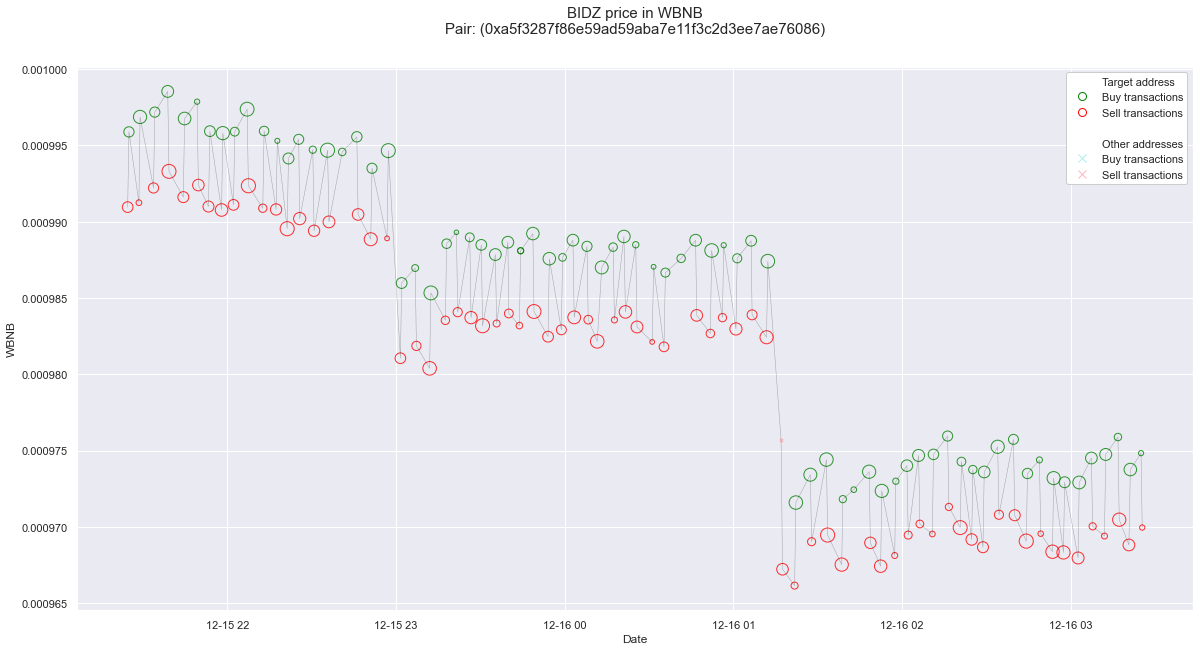

/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token0_price_in_token1"] = token0_price_in_token1
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["token1_price_in_token0"] = token1_price_in_token0


(98, 22)
(2, 22)
1.6083425865565817e+21


/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["swap_size"] = pd.to_numeric((_df.amount1In + _df.amount1Out + _df.amount0In + _df.amount0Out))
/var/folders/jr/3hbmq_8n27qg8jng87y7f4zc0000gn/T/ipykernel_12258/2061928841.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["is_buying"] = pd.to_numeric((_df.amount1In + _df.amount0Out)) > pd.to_numeric((_df.amount0In + _df.amount1Out))


In [13]:
pair_contracts = df.contract_address.unique()
print(len(pair_contracts))
d = {}

for pair in pair_contracts:
    _df = df[df.contract_address == pair]

    # if _df.shape[0] < 50:
    #     continue

    token0_price_in_token1 = pd.to_numeric((_df.amount1In + _df.amount1Out) / (_df.amount0In + _df.amount0Out)) * (10 ** (pair_info["token0_decimals"] - pair_info["token1_decimals"]))
    # accounting for token decimals shown in contract
    _df["token0_price_in_token1"] = token0_price_in_token1
    token1_price_in_token0 = 1 / token0_price_in_token1
    _df["token1_price_in_token0"] = token1_price_in_token0
    # display(_df)
    pair_info = get_pair_info(pair, abi, bsc_scan_api_key, w3)
    pair_info["signatures"] = signatures

    _df["swap_size"] = pd.to_numeric((_df.amount1In + _df.amount1Out + _df.amount0In + _df.amount0Out))

    _df["is_buying"] = pd.to_numeric((_df.amount1In + _df.amount0Out)) > pd.to_numeric((_df.amount0In + _df.amount1Out))

    most_active_address = _df.groupby('To')['transactionHash'].count().sort_values(ascending = False, kind = 'mergesort')
    if most_active_address.iloc[0] == 1:
        continue
    most_active_address = most_active_address.index[0]
    target_tx = _df[_df.To == most_active_address]
    print(target_tx.shape)
    other_tx = _df[~(_df.To == most_active_address)]

    t_mean = target_tx['swap_size'].mean()
    t_std = target_tx['swap_size'].std()

    wash_trading_data = _df[(_df['swap_size'] - t_mean) / t_std <= 3]
    other_data = _df[(_df['swap_size'] - t_mean) / t_std > 3]
    print(other_data.shape)
    position_ratio = (wash_trading_data.amount0In.sum() + wash_trading_data.amount1Out.sum() + 1) / (wash_trading_data.amount1In.sum() + wash_trading_data.amount0Out.sum() + 1)
    print(position_ratio)
    if position_ratio >= 0.8 and position_ratio <= 1.2:

        volume = _df.amount0Out.sum() + _df.amount0In.sum() + _df.amount1Out.sum() + _df.amount1In.sum()

        d[f'images/{pair_info["token1_symbol"]} price in {pair_info["token0_symbol"]}'] = (wash_trading_data.amount0Out.sum() + wash_trading_data.amount0In.sum() + 
        wash_trading_data.amount1Out.sum() + wash_trading_data.amount1In.sum(), volume, wash_trading_data.To.unique())
        plot_addresses(_df, wash_trading_data, other_data, pair_info)
    

In [12]:
v = 0
for elem in d.values():
    print(elem)
    print(elem[0]/elem[1]*100)
    v += elem[0]
print(v/(total_token0_volume_by_all_addresses + total_token1_volume_by_all_addresses)*100)

(603328231266313232994806, 621027637759093038564035, array(['0x2492724f6ce032e64aba53c00caae073122d544a',
       '0x282c0500fa5e9e0353f7d0b79c0854aaeea46a5f',
       '0x44413aa2f8d134e5b4a3eda7b804112e6cac1279',
       '0x557980f88b54f14ced5709b5bad1afd3915eb023',
       '0x98791b443499ec9f973b6921c8dd718559a5021f',
       '0xc0a572731d1db2533bf1d6521c3663cf6f60dd99',
       '0xdd2c80de528123a757698902c720c9531c529b97'], dtype=object))
97.14998086773625
(340892010438267826404237, 379581052039296151965980, array(['0x0b9e4c3298ec58a6655d06e2727733de87516e9f',
       '0xf4e6ab2ef6b593eb3d995b9c90b416d294de3152',
       '0xfac3e21ec7f380510e2161560680645c196a438c'], dtype=object))
89.8074360157938
(37697737538613660847364, 46229459319564290845052, array(['0x01b3c0afc794383e9d064920218766646dd04ecc',
       '0x086187309f525d30aee0dffc2c0254cf4f5fc7b8',
       '0x0c4796c86c7e68e99cf9fd14e928b60ef97f1720',
       '0x104f48929baab4d363ffb76ef777d9a075cc8438',
       '0x120ea98a8cbb80bc2a1c71c2